# Imports

In [1]:
import sys
sys.path.insert(0,'/content/')
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision import transforms
from helpers import UpOrTrans, Conv, get_noise, train, build_dataloader, show_tensor_images
torch.manual_seed(0)
from loss import *

# Models

In [2]:
class Generator(nn.Module):
    def __init__(self,z_dim, im_chan=3,hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.upconv1 = UpOrTrans(z_dim, hidden_dim*4, kernel_size=3, stride=2)
        self.upconv2 = UpOrTrans(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1)
        self.upconv3 = UpOrTrans(hidden_dim*2, hidden_dim, kernel_size=3, stride=2)
        self.upconv4 = UpOrTrans(hidden_dim, im_chan, kernel_size=4, stride=2, batch_norm=False)


    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        x = F.relu(self.upconv1(x))
        x = F.relu(self.upconv2(x))
        x = F.relu(self.upconv3(x))
        x = self.upconv4(x)

        return torch.tanh(x)

In [3]:
class Critic(nn.Module):
    def __init__(self, im_chan=3,hidden_dim=64):
        super(Critic, self).__init__()
        self.conv1 = Conv(im_chan, hidden_dim, padding=0)
        self.conv2 = Conv(hidden_dim,hidden_dim*2, padding=0)
        self.conv3 = Conv(hidden_dim*2,1, batch_norm=False, padding=0)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.conv3(x)
        return x.view(len(x), -1)

# Hyperparameters

In [4]:
EPOCHS = 5 # No of epochs to run
LEARNING_RATE = 0.0002 # Learning rate for Adam
BATCH = 128 # Batch size
Z_DIM= 64 # Dimension of noise vector
BETA_1 = 0.5  # Momentum for Adam
BETA_2 = 0.999  # Momentum for Adam
CRITIC_REPEAT = 5 # No of times to update Critic per generator update
GEN_REPEAT = 1    # No of times to update Generator per Critic update
C_LAMBDA = 10 # Weight of gradient penalty
DEVICE = 'cuda' # Device type

FILES_PATH = "/content/data/" # Folder where images are located
DISPLAY_STEP = 500 # show # of  the images

# Build Network

In [5]:
def build_network(device='cuda'):
    """
    Builds network    
    """
    G = Generator(z_dim=Z_DIM)
    C = Critic()
    if device=='cuda':
        G = Generator(z_dim=Z_DIM).cuda()
        C = Critic().cuda()
        
    def weight_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, 0.0, 0.02)
            torch.nn.init.constant_(m.bias, 0)

    G.apply(weight_init)
    C.apply(weight_init)
    return G, C

# Initialize Network and Optimizers

In [6]:
G, C = build_network(DEVICE)
G_opt = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))
C_opt = optim.Adam(C.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))

data_loader = build_dataloader(FILES_PATH, batch=BATCH, image_dim=28)

# Uncomment it to use Pytorch datasets instead

# transform = transforms.Compose([
#     transfoms.Resize(28,28),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,)),
# ])

# dataloader = DataLoader(
#     datasets.CelebA('.', download=False, transform=transform),
#     batch_size=batch_size,
#     shuffle=True)

# Train

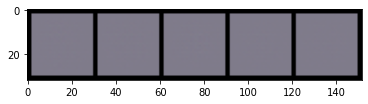

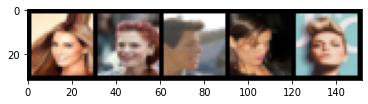

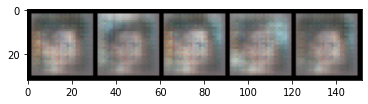

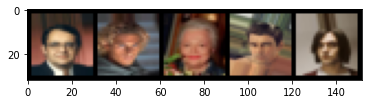

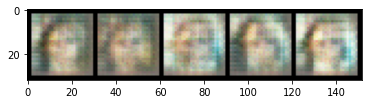

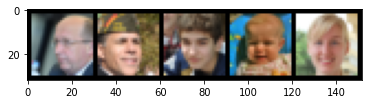

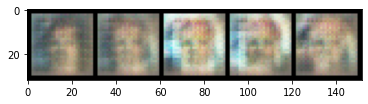

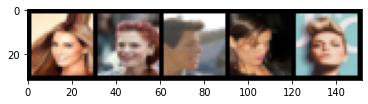

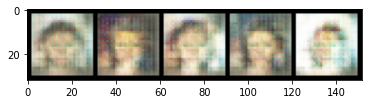

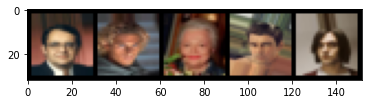

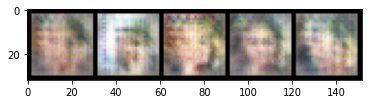

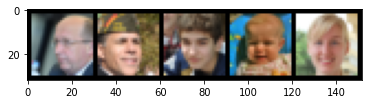

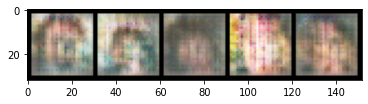

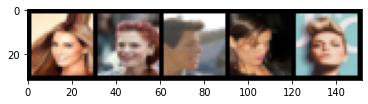

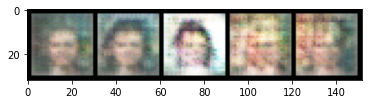

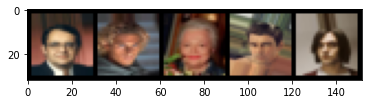

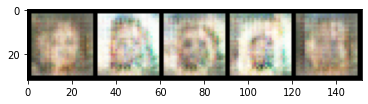

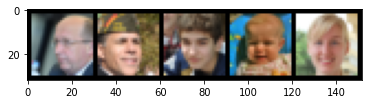

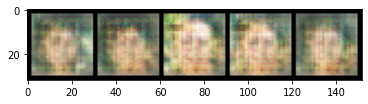

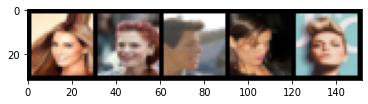

KeyboardInterrupt: ignored

In [ ]:
train(data_loader,
      G, C,
      G_opt, C_opt,
      n_epochs = EPOCHS,
      device = DEVICE,
      critic_repeat = CRITIC_REPEAT,
      gen_repeat = GEN_REPEAT,
      display_step = DISPLAY_STEP,
      z_dim = Z_DIM,
      c_lambda = C_LAMBDA
     )

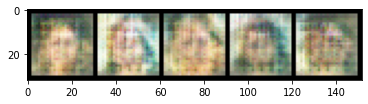

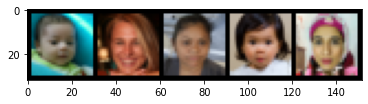

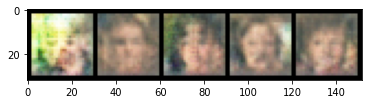

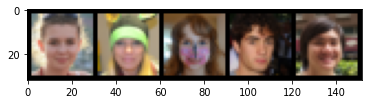

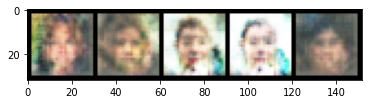

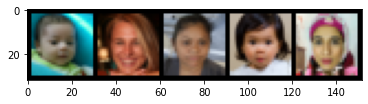

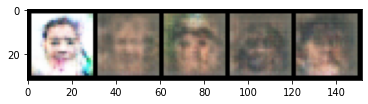

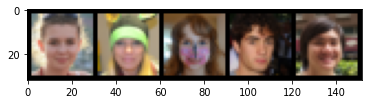

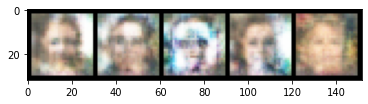

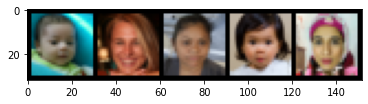

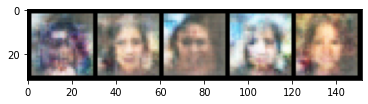

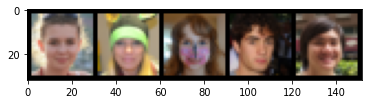

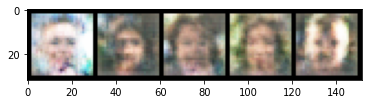

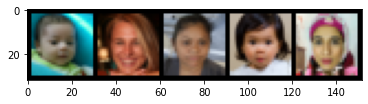

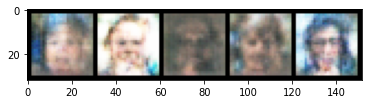

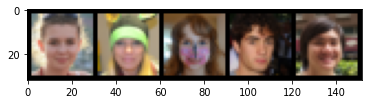

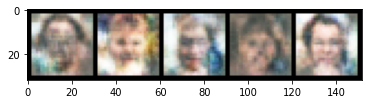

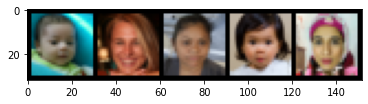

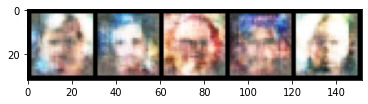

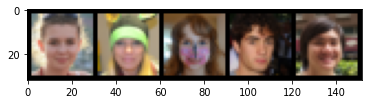

In [ ]:
G.load_state_dict(torch.load('G.pth'))
train(data_loader,
      G, C,
      G_opt, C_opt,
      n_epochs = EPOCHS,
      device = DEVICE,
      critic_repeat = CRITIC_REPEAT,
      gen_repeat = GEN_REPEAT,
      display_step = DISPLAY_STEP,
      z_dim = Z_DIM,
      c_lambda = C_LAMBDA
     )

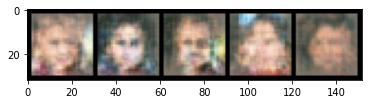

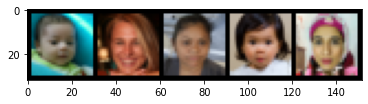

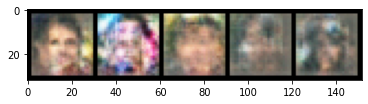

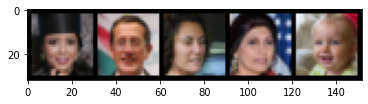

In [ ]:
G.load_state_dict(torch.load('G.pth'))
train(data_loader,
      G, C,
      G_opt, C_opt,
      n_epochs = 1,
      device = DEVICE,
      critic_repeat = CRITIC_REPEAT,
      gen_repeat = GEN_REPEAT,
      display_step = 546,
      z_dim = Z_DIM,
      c_lambda = C_LAMBDA
     )

# Test <p hidden>😎</p>

In [7]:
G.load_state_dict(torch.load('G.pth'))

<All keys matched successfully>

In [37]:
def generate_images(gen_model, no_of_images, device='cuda', name=None):
    gen_model = gen_model.eval()
    with torch.no_grad():
        show_tensor_images(gen_model(get_noise(no_of_images, 64,device)), num_images=no_of_images, name=name)

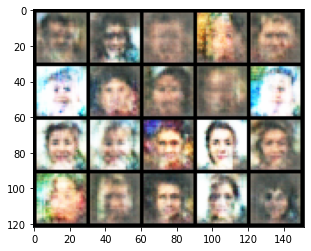

In [40]:
generate_images(G, no_of_images=20, device=DEVICE)

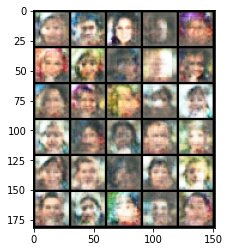

In [41]:
generate_images(G, no_of_images=30, device=DEVICE)

In [42]:
# for i in range(10000):
#     generate_images(G, no_of_images=30, device=DEVICE, name='/content/images/{}'.format(i))